In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shutil
import random
from pathlib import Path
warnings.filterwarnings("ignore", category=UserWarning, message=".*NumPy version.*")

# Paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

In [2]:
# Credit: https://github.com/sberbank-ai/ru-dalle/blob/e96631a867fcadcfaa52eecb20b1e42b88aa4386/rudalle/utils.py
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## EDA: Dataset Overview

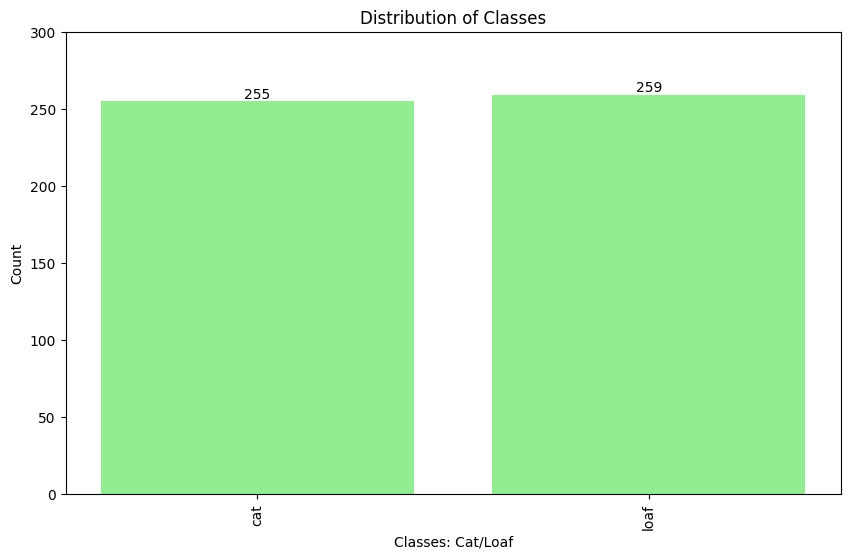

In [3]:
# Get a list of subdirectories 
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each cat/loaf folder
label_counts = {target: len(os.listdir(os.path.join(train_dir, target))) for target in class_dirs}

plt.figure(figsize=(10,6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='lightgreen')
plt.title('Distribution of Classes')
plt.xlabel('Classes: Cat/Loaf')
plt.ylabel('Count')

# Set y-ticks from 0 to the max count with an interval of 100
plt.yticks(range(0, max(label_counts.values()) + 50, 50))

plt.xticks(rotation=90)

# Add count labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

In [4]:
print(f"Total number of Images: {sum(label_counts.values())}")

Total number of Images: 514


### Checking file consistency

In [5]:
import imghdr

global_inconsistent_files = []

def check_file_types(directory):
    '''
    Function for checking file inconsistencies. The only valid formats accepted are 'jpeg', 'jpg', and 'png'
    ''' 
    valid_formats = {'jpeg', 'jpg', 'png'}
    inconsistent_files = []

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_type = imghdr.what(file_path)
                                  
            if file_type not in valid_formats:
                # Capture the relative path of the file
                relative_path = os.path.relpath(file_path, directory)
                inconsistent_files.append((relative_path, file_type))
                    
    if inconsistent_files:
        print("Inconsistent files found:")
        for file, file_type in inconsistent_files:
            global_inconsistent_files.append(train_dir+'/'+file)
            print(f"{file}: {file_type}")
    else:
        print("All files have consistent formats.")

check_file_types(train_dir)

All files have consistent formats.


/tmp/ipykernel_82742/2874414244.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
from PIL import Image

classes = os.listdir(train_dir)
dimensions = []
for cls in classes:
    for img_name in os.listdir(os.path.join(train_dir, cls)):
        if img_name != '.ipynb_checkpoints':
            img = Image.open(os.path.join(train_dir, cls, img_name))
            dimensions.append(img.size)

# check for dimensions
pd.DataFrame(dimensions).value_counts()

0    1  
100  100    512
Name: count, dtype: int64

From the dataset source, it was mentioned that the images have been standardized to 100x100.

### Checking corrupted files

In [7]:
def check_image(file_path):
    '''
    Checking for corrupted files by opening them one by one.
    '''
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verifies if the image is not corrupted
        return True
    except (IOError, SyntaxError):
        return False
        
def check_dataset_integrity(dataset_dir):
    has_corrupted_file = False
    for class_dir in classes:
        class_path = os.path.join(train_dir, class_dir)
        if os.path.isdir(class_path):  # Only process directories
            corrupted_files = 0
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))] # extract images directories from both subdirectory
            
            # Check for each image
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                if not check_image(image_path):
                    corrupted_files += 1

            # If there are corrupted files, print the class and details
            if corrupted_files > 0:
                has_corrupted_file = True
                print(f"Processing species: {class_dir}")
                print(f"Found {corrupted_files} corrupted files in '{class_dir}' directory.")
    
    # If no corrupted files were found
    if not has_corrupted_file:
        print("No corrupted files found.")

check_dataset_integrity(train_dir)

No corrupted files found.


### Pixel Intensity

/tmp/ipykernel_82742/475709622.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pixel_values.append(np.array(ToTensor()(img)).flatten())


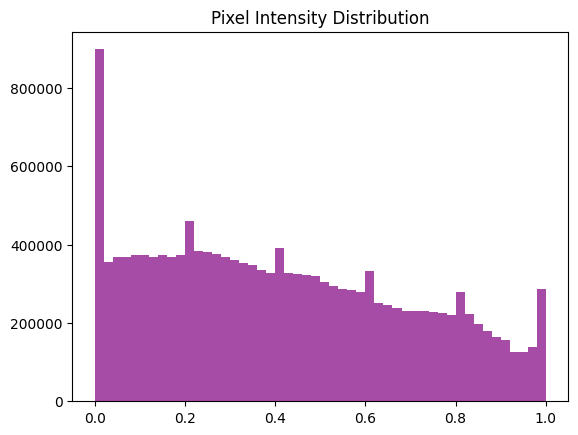

In [8]:
pixel_values = []
for cls in classes:
    for img_name in os.listdir(os.path.join(train_dir, cls)):
        if img_name != '.ipynb_checkpoints':
            img = Image.open(os.path.join(train_dir, cls, img_name))
            pixel_values.append(np.array(ToTensor()(img)).flatten())

pixel_values = np.concatenate(pixel_values)
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.show()

### Looking at the images

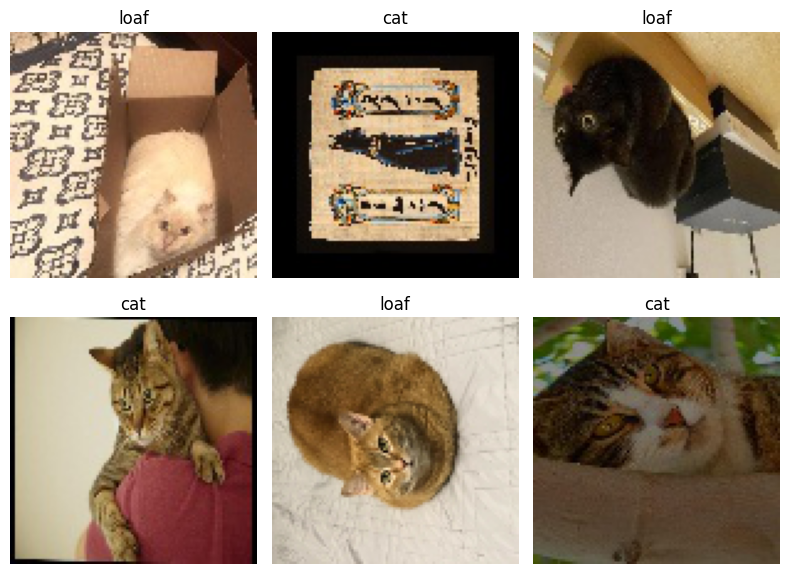

In [9]:
# Visualization
figure = plt.figure(figsize=(8, 6))
cols, rows = 3, 2

cat_path = os.path.join(train_dir, 'cat')
cat_images = [f for f in os.listdir(cat_path) if os.path.isfile(os.path.join(cat_path, f))]

loaf_path = os.path.join(train_dir, 'loaf')
loaf_images = [f for f in os.listdir(loaf_path) if os.path.isfile(os.path.join(loaf_path, f))]

for i in range(1, cols * rows + 1):
    if i % 2 == 0:  # Even index, choose from cats
        sample_idx = torch.randint(len(cat_images), size=(1,)).item()
        img_path = os.path.join(cat_path, cat_images[sample_idx])
        label = 'cat'
    else:  # Odd index, choose from loaves
        sample_idx = torch.randint(len(loaf_images), size=(1,)).item()
        img_path = os.path.join(loaf_path, loaf_images[sample_idx])
        label = 'loaf'

    # Load image and plot
    img = Image.open(img_path)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

I will be deleting some images from 'cat' folder due to having images that are not cats.

## Model Training

For this case, I'm going to use ResNet18 - a pretrained model.

In [10]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0);

In [11]:
# common classificaton pipeline from
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
train_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(224, 224)), # resizing directly because data augmentation has already been done on the dataset
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(256, 256)),
    v2.CenterCrop(size=(224, 224)),
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

# DataLoader (for batching and shuffling)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)
# Ensure workers have deterministic behavior
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
img, label = train_dataset[0]
print(f"Image shape: {img.shape}, Label: {label}")

Image shape: torch.Size([3, 224, 224]), Label: 0


In [13]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # pause a bit so that plots are updated

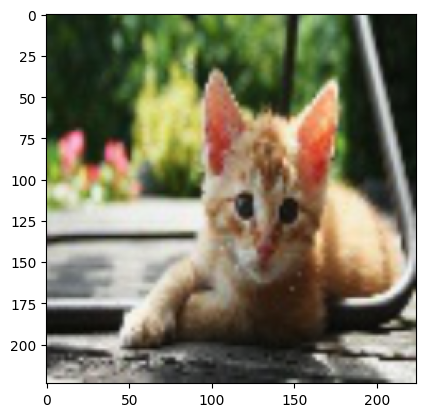

In [14]:
imshow(img);

In [15]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16]) torch.int64


In [16]:
# CREATE CNN AND RESNET
# APPLY TUNING
# CREATE DOCUMENTATION

In [17]:
len(train_loader.dataset)

514

In [18]:
device

device(type='cuda', index=0)

### General training function

In [19]:
import time
from tempfile import TemporaryDirectory

dataloaders = {
    'train': train_loader,
    'val': test_loader
}

dataset_sizes = {
    'train': len(train_loader.dataset),
    'val':len(test_loader.dataset)
}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        
                        if isinstance(model, models.inception.Inception3) and phase == 'train':
                            outputs = outputs.logits
                            
                        #print(outputs)
                        preds = (outputs > 0.5).long() # For binary classification, use a threshold of 0.5
                        loss = criterion(outputs, labels.unsqueeze(1).float())
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.unsqueeze(1))

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                # print("Predictions: ", preds, '\n', "Labels: ", labels.unsqueeze(1), '\n', "\nTest: ", running_corrects.double())
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                if phase == 'val':
                    scheduler.step(epoch_loss)
                    
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

### Base Model: Using ResNet18

#### ResNet18

In [20]:
import torchvision.models as models
from torch.optim import lr_scheduler

model = models.resnet18(weights='IMAGENET1K_V1')

# Number of input features in the final layer
num_features = model.fc.in_features  

# Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 class for binary classification
    nn.Sigmoid()  # Activation for binary classification
)

# move to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model outputs
            outputs = model(inputs)
            preds = (outputs > 0.5).long()  # Apply sigmoid to logits

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]} | actual: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
def test_accuracy(img_model):
    # Initialize variables to keep track of correct predictions and total samples
    correct_preds = 0
    total_preds = 0
    
    img_model.eval()
    
    # Disable gradient computation for evaluation (this reduces memory usage)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # Forward pass through the model
            outputs = img_model(inputs)
            # # Check if the model is InceptionV3 and extract logits
            # if isinstance(img_model, models.inception.Inception3):
            #     logits = outputs.logits  # This is the tensor of raw model outputs
            # else:
            #     logits = outputs  # For other models, use the output directly
                
            # Get predicted class (highest probability)
            preds = (outputs > 0.5).long()  # For binary classification, use a threshold of 0.5
            
            # Update the number of correct predictions
            correct_preds += torch.sum(preds.squeeze() == labels).item()
            total_preds += labels.size(0)
    
    # Calculate accuracy
    accuracy = correct_preds / total_preds
    return accuracy * 100

np.round(test_accuracy(model),2)

np.float64(50.39)

It is highly likely that the model is always predicting 'cat' due to ImageNet by default.

### Model Selection

#### Fine tuning for Resnet18

#### Training the last layer

In [24]:
model = models.resnet18(weights='IMAGENET1K_V1')

# Number of input features in the final layer
num_features = model.fc.in_features  

# Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 class for binary classification
    nn.Sigmoid()  # sigmoid activation
)

# move to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# reduce lr on plateau
# https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, patience=5, 
    cooldown=2, 
    threshold=0.01
) # it seems that for smaller datasets, it is better to use a lr_scheduler

# freeze layers and unfreeze last layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6854 Acc: 0.5623
val Loss: 0.6002 Acc: 0.7287

Epoch 2/10
----------
train Loss: 0.5645 Acc: 0.7062
val Loss: 0.5333 Acc: 0.7674

Epoch 3/10
----------
train Loss: 0.4924 Acc: 0.8054
val Loss: 0.4830 Acc: 0.7984

Epoch 4/10
----------
train Loss: 0.4627 Acc: 0.8366
val Loss: 0.4895 Acc: 0.7597

Epoch 5/10
----------
train Loss: 0.4049 Acc: 0.8346
val Loss: 0.4491 Acc: 0.8217

Epoch 6/10
----------
train Loss: 0.4051 Acc: 0.8288
val Loss: 0.4533 Acc: 0.7984

Epoch 7/10
----------
train Loss: 0.3722 Acc: 0.8463
val Loss: 0.4316 Acc: 0.8062

Epoch 8/10
----------
train Loss: 0.3336 Acc: 0.8833
val Loss: 0.4122 Acc: 0.8062

Epoch 9/10
----------
train Loss: 0.3360 Acc: 0.8774
val Loss: 0.4032 Acc: 0.8295

Epoch 10/10
----------
train Loss: 0.3075 Acc: 0.9125
val Loss: 0.3941 Acc: 0.8295

Training complete in 0m 9s
Best val Acc: 0.829457


#### resnet18 optimizer learning rate

In [25]:
%%capture

lr_list = [0.1, 0.01, 0.010, 0.005, 0.001]
best_stats = {}

for lr in lr_list:
    print(f"LEARNING RATE = {lr}")
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Number of input features in the final layer
    num_features = model.fc.in_features  
    
    # Replace the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),  # Output 1 class for binary classification
        nn.Sigmoid()  # Activation for binary classification
    )
    
    # move to cuda
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
    # reduce lr on plateau
    # https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, patience=5, 
        cooldown=2, 
        threshold=0.01
    ) # it seems that for smaller datasets, it is better to use a lr_scheduler
    
    # freeze layers and unfreeze last layer
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.fc.parameters():
        param.requires_grad = True
    
    model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)
    best_stats[f"optimizer_lr={lr}"] = test_accuracy(model)

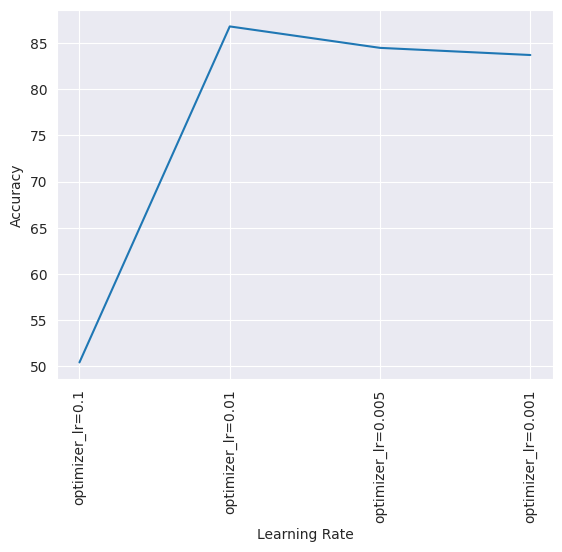

In [26]:
df = pd.DataFrame(list(best_stats.items()), columns=['Learning Rate', 'Accuracy'])

sns.set_style('darkgrid')

sns.lineplot(data=df, x='Learning Rate', y='Accuracy', markers=True)
plt.xticks(rotation=90)
plt.show();

I'll go with 0.005 learning rate for the optimizer. This is because the difference between the other is negligible.

#### resnet18 dropout

In [27]:
%%capture

dropout_list = [0.3, 0.35, 0.4, 0.45, 0.5]
best_stats = {}

for drp in dropout_list:
    print(f"Dropout = {drp}")
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Number of input features in the final layer
    num_features = model.fc.in_features  
    
    # Replace the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),  # Output 1 class for binary classification
        nn.Dropout(p=drp), # dropout for reducing overfitting due to small dataset
        nn.Sigmoid()  # Activation for binary classification
    )
    
    # move to cuda
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.005)
    
    # reduce lr on plateau
    # https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, patience=5, 
        cooldown=2, 
        threshold=0.01
    ) # it seems that for smaller datasets, it is better to use a lr_scheduler
    
    # freeze layers and unfreeze last layer
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.fc.parameters():
        param.requires_grad = True
    
    model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)
    best_stats[f"dropout={drp}"] = test_accuracy(model)

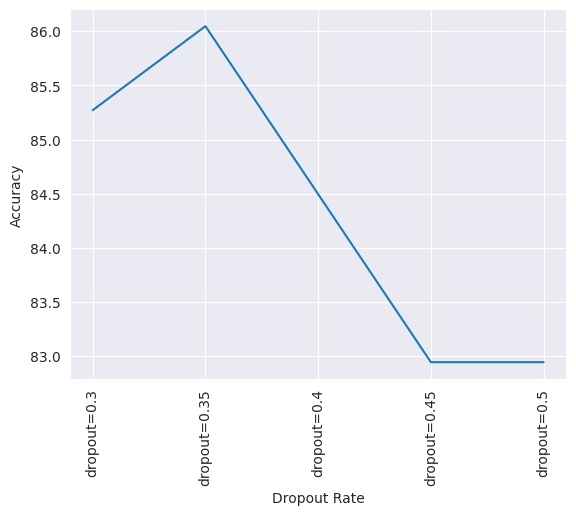

In [28]:
df = pd.DataFrame(list(best_stats.items()), columns=['Dropout Rate', 'Accuracy'])

sns.set_style('darkgrid')

sns.lineplot(data=df, x='Dropout Rate', y='Accuracy', markers=True)
plt.xticks(rotation=90)
plt.show();

#### Final resnet18 model

In [29]:
model = models.resnet18(weights='IMAGENET1K_V1')

# Number of input features in the final layer
num_features = model.fc.in_features  

# Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 class for binary classification
    nn.Dropout(p=0.5), # dropout for reducing overfitting due to small dataset
    nn.Sigmoid()  # Activation for binary classification
)

# move to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.005)

# reduce lr on plateau
# https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, patience=5, 
    cooldown=2, 
    threshold=0.01
) # it seems that for smaller datasets, it is better to use a lr_scheduler

# freeze layers and unfreeze last layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6893 Acc: 0.5992
val Loss: 0.5193 Acc: 0.7442

Epoch 2/10
----------
train Loss: 0.6236 Acc: 0.6187
val Loss: 0.4588 Acc: 0.7907

Epoch 3/10
----------
train Loss: 0.4664 Acc: 0.6887
val Loss: 0.4637 Acc: 0.7674

Epoch 4/10
----------
train Loss: 0.5106 Acc: 0.6751
val Loss: 0.4388 Acc: 0.7829

Epoch 5/10
----------
train Loss: 0.4980 Acc: 0.6868
val Loss: 0.3964 Acc: 0.8295

Epoch 6/10
----------
train Loss: 0.4557 Acc: 0.6907
val Loss: 0.4105 Acc: 0.8140

Epoch 7/10
----------
train Loss: 0.4956 Acc: 0.6790
val Loss: 0.4676 Acc: 0.7674

Epoch 8/10
----------
train Loss: 0.5025 Acc: 0.6634
val Loss: 0.3850 Acc: 0.8217

Epoch 9/10
----------
train Loss: 0.4668 Acc: 0.6926
val Loss: 0.3647 Acc: 0.8450

Epoch 10/10
----------
train Loss: 0.5447 Acc: 0.6362
val Loss: 0.4970 Acc: 0.7752

Training complete in 0m 9s
Best val Acc: 0.844961


In [30]:
np.round(test_accuracy(model), 2)

np.float64(84.5)

#### Inception V3

In [31]:
# common classificaton pipeline from
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
train_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(299, 299)), # resizing directly because data augmentation has already been done on the dataset
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(299, 299)),
    v2.CenterCrop(size=(299, 299)),
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

# DataLoader (for batching and shuffling)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)
# Ensure workers have deterministic behavior
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img, label = train_dataset[0]
print(f"Image shape: {img.shape}, Label: {label}")

Image shape: torch.Size([3, 299, 299]), Label: 0


In [32]:
model = models.inception_v3(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features  # The input features to the final fully connected layer

# Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),  # Output 1 class for binary classification
    nn.Sigmoid()  # Activation for binary classification
)

# move to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [33]:
test_accuracy(model)

43.41085271317829

#### Fine-tuning last layer for Inception V3

In [34]:
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

dataset_sizes = {
    'train': len(train_loader.dataset),
    'val':len(test_loader.dataset)
}

model = models.inception_v3(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features  # The input features to the final fully connected layer

# Replace the fully connected layer
# by default, inception_v3 has dropout of 0.5
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),  # Output 1 class for binary classification
    nn.Sigmoid()  # Activation for binary classification
)

# move to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# reduce lr on plateau
# https://medium.com/data-scientists-diary/guide-to-pytorch-learning-rate-scheduling-b5d2a42f56d4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, patience=5, 
    cooldown=2, 
    threshold=0.01
) # it seems that for smaller datasets, it is better to use a lr_scheduler

# freeze layers and unfreeze last layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6718 Acc: 0.5720
val Loss: 0.6084 Acc: 0.7209

Epoch 2/10
----------
train Loss: 0.5813 Acc: 0.7198
val Loss: 0.5644 Acc: 0.7519

Epoch 3/10
----------
train Loss: 0.5237 Acc: 0.7918
val Loss: 0.5756 Acc: 0.7364

Epoch 4/10
----------
train Loss: 0.4886 Acc: 0.7802
val Loss: 0.5086 Acc: 0.7752

Epoch 5/10
----------
train Loss: 0.4787 Acc: 0.7996
val Loss: 0.4777 Acc: 0.7907

Epoch 6/10
----------
train Loss: 0.4476 Acc: 0.8346
val Loss: 0.4478 Acc: 0.8605

Epoch 7/10
----------
train Loss: 0.4294 Acc: 0.8307
val Loss: 0.4405 Acc: 0.8295

Epoch 8/10
----------
train Loss: 0.3966 Acc: 0.8444
val Loss: 0.4485 Acc: 0.7984

Epoch 9/10
----------
train Loss: 0.3967 Acc: 0.8658
val Loss: 0.4190 Acc: 0.8527

Epoch 10/10
----------
train Loss: 0.3879 Acc: 0.8463
val Loss: 0.4032 Acc: 0.8837

Training complete in 0m 22s
Best val Acc: 0.883721


In [35]:
final_model = model

Inception_v3 seems to work better based on the runs I've made.

#### Custom Neural Network Architecture

In [36]:
# common classificaton pipeline from
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
train_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(100, 100)), # resizing directly because data augmentation has already been done on the dataset
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(100, 100)),
    v2.CenterCrop(size=(100, 100)),
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

# DataLoader (for batching and shuffling)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)
# Ensure workers have deterministic behavior
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': test_loader
}

dataset_sizes = {
    'train': len(train_loader.dataset),
    'val':len(test_loader.dataset)
}

In [37]:
import torch
import torch.nn as nn

class SimpleCNNWithDropout(nn.Module):
    def __init__(self):
        super(SimpleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3x100x100
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x100x100
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Pooling: 64x50x50
        self.fc1 = nn.Linear(64 * 50 * 50, 1)  # Adjusted fully connected layer (64 channels, 50x50 feature map after pooling)
        self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Apply ReLU after the first convolution
        x = self.relu(self.conv2(x))  # Apply ReLU after the second convolution
        x = self.avg_pool(x)  # Apply average pooling (output: 64x50x50)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer (output: 64*50*50)
        x = self.dropout(x)  # Apply dropout before the fully connected layer
        x = self.fc1(x)  # Output layer for binary classification (raw logits)
        return x

# Move the model to the correct device (e.g., GPU if available)
device = 'cpu'
model = SimpleCNNWithDropout().to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss (requires probabilities as input)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, patience=5, 
    cooldown=2, 
    threshold=0.01
)

# Example input: batch of 16 images with 3 channels and 100x100 size
dummy_input = torch.randn(16, 3, 100, 100).to(device)

# Forward pass through the model
logits = model(dummy_input)  # Get raw logits
probs = torch.sigmoid(logits)  # Apply sigmoid to get probabilities

# Print the output (probabilities)
print(probs)

tensor([[0.5042],
        [0.4997],
        [0.4967],
        [0.4923],
        [0.4584],
        [0.4512],
        [0.4798],
        [0.5124],
        [0.4692],
        [0.4960],
        [0.4818],
        [0.4915],
        [0.5050],
        [0.4850],
        [0.4654],
        [0.4828]], grad_fn=<SigmoidBackward0>)


In [38]:
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)  # Raw logits
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        
        # Compute loss (use probabilities for BCELoss)
        loss = criterion(probs.squeeze(), labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item() * images.size(0)
        
        # Compute accuracy
        predictions = torch.round(probs)  # Round probabilities to get binary predictions
        correct = (predictions.squeeze() == labels).float().sum()
        epoch_correct += correct.item()
        epoch_total += labels.size(0)
    
    # Print epoch statistics
    epoch_loss /= epoch_total  # Average loss over the epoch
    epoch_accuracy = epoch_correct / epoch_total  # Accuracy over the epoch
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(
        epoch+1, num_epochs, epoch_loss, epoch_accuracy))

Epoch [1/20], Loss: 0.7881, Accuracy: 0.5486
Epoch [2/20], Loss: 0.6321, Accuracy: 0.6323
Epoch [3/20], Loss: 0.5816, Accuracy: 0.6868
Epoch [4/20], Loss: 0.5382, Accuracy: 0.7354
Epoch [5/20], Loss: 0.4978, Accuracy: 0.7821
Epoch [6/20], Loss: 0.4640, Accuracy: 0.7840
Epoch [7/20], Loss: 0.4279, Accuracy: 0.8191
Epoch [8/20], Loss: 0.3829, Accuracy: 0.8541
Epoch [9/20], Loss: 0.3834, Accuracy: 0.8482
Epoch [10/20], Loss: 0.3408, Accuracy: 0.8774
Epoch [11/20], Loss: 0.2803, Accuracy: 0.9066
Epoch [12/20], Loss: 0.2416, Accuracy: 0.9339
Epoch [13/20], Loss: 0.2698, Accuracy: 0.9047
Epoch [14/20], Loss: 0.2301, Accuracy: 0.9319
Epoch [15/20], Loss: 0.1850, Accuracy: 0.9494
Epoch [16/20], Loss: 0.1873, Accuracy: 0.9416
Epoch [17/20], Loss: 0.1709, Accuracy: 0.9572
Epoch [18/20], Loss: 0.1484, Accuracy: 0.9650
Epoch [19/20], Loss: 0.1041, Accuracy: 0.9864
Epoch [20/20], Loss: 0.2231, Accuracy: 0.9125


In [39]:
test_accuracy(model)

59.68992248062015

I'm getting poor accuracy on the validation set so this is definitely overfitting.

## Custom Test

In [40]:
# common classificaton pipeline from
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
train_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(299, 299)), # resizing directly because data augmentation has already been done on the dataset
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(299, 299)),
    v2.CenterCrop(size=(299, 299)),
    v2.ToImage(), # To image and dtype torch.float32 becuase v2.ToTensor() is deprecated
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def visualize_model_predictions(model, img_path, device='cuda'):
    was_training = model.training
    model.eval()  # Set model to evaluation mode
    
    # Load the image
    img = Image.open(img_path).convert('RGB')
    
    # Transform the image (resize, normalize, etc.)
    img = val_transforms(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to('cuda')  # Move to GPU 

    with torch.no_grad():
        # Forward pass through the model
        outputs = model(img)
        preds = (outputs > 0.5).long()  # Sigmoid and thresholding for binary classification
        
        # Plot the image and prediction
        fig, ax = plt.subplots(1, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {"Loaf" if preds[0].item() == 1 else "Cat"}')
        imshow(img.cpu().data[0])  # Show the image
        
    model.train(mode=was_training)  # Restore the model to its original training mode

In [43]:
type(final_model)

torchvision.models.inception.Inception3

### Cat Test

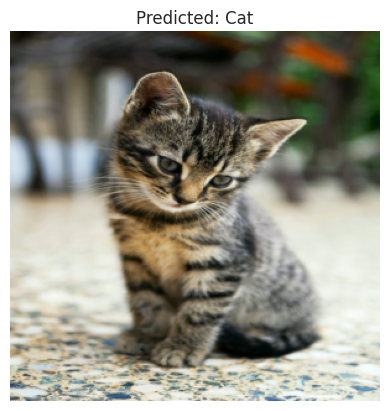

In [41]:
visualize_model_predictions(
    final_model,
    img_path='custom_test_img/cat.jpeg'
);

plt.ioff();

### Loaf Test

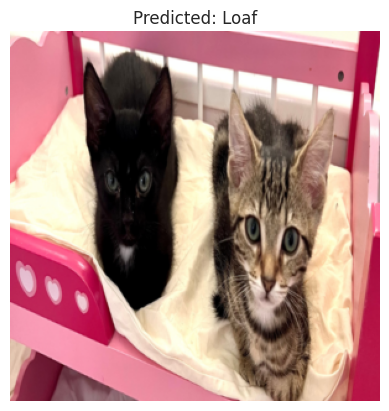

In [42]:
visualize_model_predictions(
    final_model,
    img_path='custom_test_img/loaf.png'
);